# ***Import Package***

In [46]:
import numpy as np
import pandas as pd

from functools import reduce
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import seaborn as sns

# ***Fetching Raw Data***

## Raw listing.csv

In [47]:
# get listings data
listing_df = pd.read_csv("data/listings.csv")

In [48]:
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17891,https://www.airbnb.com/rooms/17891,20210924202443,2021-09-25,Large Light Filled Loft,"Gorgeous and spacious loft, in the best locati...",Best neighborhood in Hong Kong! A mix of old a...,https://a0.muscache.com/pictures/119686/6ced58...,69063,https://www.airbnb.com/users/show/69063,...,4.93,4.90,4.66,NaN,f,1,1,0,0,1.08
1,69074,https://www.airbnb.com/rooms/69074,20210924202443,2021-09-25,Beautiful oasis of plants & art @ best location,An ideal Hong location any visitor--hip withou...,"In the upper part of trendy, hip Sheung Wan, w...",https://a0.muscache.com/pictures/84364564/1e0c...,160139,https://www.airbnb.com/users/show/160139,...,4.91,4.90,4.69,NaN,f,1,1,0,0,1.20
2,103760,https://www.airbnb.com/rooms/103760,20210924202443,2021-09-25,Central Centre 5 min walk to/from Central MTR,"Located right in the heart of Central, this 2 ...",NaN,https://a0.muscache.com/pictures/815221/056993...,304876,https://www.airbnb.com/users/show/304876,...,4.60,4.72,4.40,NaN,f,9,5,4,0,3.08
3,104626,https://www.airbnb.com/rooms/104626,20210924202443,2021-09-25,Entire Flat - Next to Man Mo Temple,<b>The space</b><br />Situated in one of Hong ...,NaN,https://a0.muscache.com/pictures/1947265/ef01a...,544166,https://www.airbnb.com/users/show/544166,...,4.93,4.79,4.71,NaN,f,1,1,0,0,0.12
4,132773,https://www.airbnb.com/rooms/132773,20210924202443,2021-09-25,Fabulous 2 Bdrm Aprt Open kitchen,"Nicely decorated, spacious 2 bedroom apartment...",The Sheung Wan neighbourhood is ever changing ...,https://a0.muscache.com/pictures/36936441/e4c1...,304876,https://www.airbnb.com/users/show/304876,...,4.64,4.40,4.38,NaN,f,9,5,4,0,2.48


## Raw review.csv

In [49]:
review_df = pd.read_csv("data/reviews_summary.csv")

In [50]:
print(review_df.shape)
review_df.head()

(106509, 2)


,listing_id,date
0,17891,2010-04-23
1,17891,2010-06-24
2,17891,2010-08-09
3,17891,2010-09-09
4,17891,2010-09-29


## Raw calendar.csv

In [51]:
calendar_df = pd.read_csv("data/calendar.csv")

In [52]:
calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,728126,2021-09-25,f,$495.00,$495.00,24.0,365.0
1,1980360,2021-09-25,f,$250.00,$250.00,2.0,1125.0
2,1980360,2021-09-26,f,$250.00,$250.00,2.0,1125.0
3,1980360,2021-09-27,t,$250.00,$250.00,2.0,1125.0
4,1980360,2021-09-28,t,$250.00,$250.00,2.0,1125.0
...,...,...,...,...,...,...,...
2206421,52295948,2022-09-20,t,$710.00,$710.00,28.0,1125.0
2206422,52295948,2022-09-21,t,$710.00,$710.00,28.0,1125.0
2206423,52295948,2022-09-22,t,$710.00,$710.00,28.0,1125.0
2206424,52295948,2022-09-23,t,$710.00,$710.00,28.0,1125.0


# ***Q1: District with greatest revenue***

## prepare listing & review dataframe for Q1

In [53]:
# Get listing dataframe for Q1
column_for_Q1 = ['id', 'neighbourhood_cleansed', 'price', \
                 'minimum_nights', 'host_since', 'first_review', \
                 'last_review', 'number_of_reviews']
                 
listing_df_Q1 = listing_df[column_for_Q1].copy()

In [54]:
# Check data cleanliness
print(listing_df_Q1.duplicated(subset = ['id']).sum(), '\n')
print(listing_df_Q1.isnull().sum())

0 

id                           0
neighbourhood_cleansed       0
price                        0
minimum_nights               0
host_since                   1
first_review              3067
last_review               3067
number_of_reviews            0
dtype: int64


In [55]:
# Data cleaning
listing_df_Q1.dropna(subset = ['host_since', 'first_review'], how = 'any', inplace = True)
print(listing_df_Q1.isnull().sum())

id                        0
neighbourhood_cleansed    0
price                     0
minimum_nights            0
host_since                0
first_review              0
last_review               0
number_of_reviews         0
dtype: int64


In [56]:
# Data Wrangling
listing_df_Q1.rename(columns={'id':'listing_id'}, inplace = True)
listing_df_Q1['price'] = listing_df_Q1['price'].str.replace("[$,]", "").astype("float")
listing_df_Q1['host_since'] = pd.to_datetime(listing_df_Q1['host_since'])
listing_df_Q1['first_review'] = pd.to_datetime(listing_df_Q1['first_review'])
listing_df_Q1['last_review'] = pd.to_datetime(listing_df_Q1['last_review'])

C:\Users\USER\AppData\Local\Temp/ipykernel_10628/2870841483.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  listing_df_Q1['price'] = listing_df_Q1['price'].str.replace("[$,]", "").astype("float")


In [57]:
# Prepare review dataframe for Q1
review_df_Q1 = review_df.copy()

In [58]:
# Check data cleanliness
print(review_df_Q1.isnull().sum())

listing_id    0
date          0
dtype: int64


In [59]:
# Data Wrangling
review_df_Q1['date'] = pd.to_datetime(review_df_Q1['date']) # convert to datetime

In [60]:
review_df_Q1

,listing_id,date
0,17891,2010-04-23
1,17891,2010-06-24
2,17891,2010-08-09
3,17891,2010-09-09
4,17891,2010-09-29
...,...,...
106504,52196922,2021-09-13
106505,52196922,2021-09-17
106506,52196922,2021-09-18
106507,52208871,2021-09-19


## Calculate estimated total revenue since 2014-06-05

In [61]:
# Check the date that every neighbourhood has at least one listing
print(listing_df_Q1.groupby(['neighbourhood_cleansed']).agg({'host_since': ['min']}), '\n')
print(listing_df_Q1.groupby(['neighbourhood_cleansed']).agg({'host_since': ['min']}).max())

                       host_since
                              min
neighbourhood_cleansed           
Central & Western      2010-01-09
Eastern                2012-06-28
Islands                2010-02-20
Kowloon City           2012-06-26
Kwai Tsing             2014-02-11
Kwun Tong              2014-04-11
North                  2012-11-01
Sai Kung               2011-07-27
Sha Tin                2011-04-14
Sham Shui Po           2011-10-09
Southern               2012-03-04
Tai Po                 2012-07-18
Tsuen Wan              2014-06-05
Tuen Mun               2013-07-31
Wan Chai               2011-04-21
Wong Tai Sin           2013-01-04
Yau Tsim Mong          2011-05-01
Yuen Long              2011-11-26 

host_since  min   2014-06-05
dtype: datetime64[ns]


In [62]:
# Remove listings that have not been reviewed since 2014-06-05
listing_df_Q1_cal = listing_df_Q1.loc[listing_df_Q1.last_review > '2014-06-05', :].copy()

In [63]:
# Find listings' number of review given after 2014-06-05
df_review_num_after_2014_06_05 = \
review_df_Q1.where(review_df_Q1.date >= '2014-06-05').groupby(['listing_id']).count()

df_review_num_after_2014_06_05.rename(columns={"date": "review_num_after_2014_06_05"}, inplace = True)

listing_df_Q1_cal = \
listing_df_Q1_cal.merge(df_review_num_after_2014_06_05, how = 'inner', on = 'listing_id')


# Remove listings with abnormal review number
listing_df_Q1_cal['max_possible_review_num'] = \
( (listing_df_Q1_cal.loc[:, 'last_review'] \
   - listing_df_Q1_cal.loc[:, 'first_review']) \
   / listing_df_Q1_cal.loc[:, 'minimum_nights'] ).dt.days

listing_df_Q1_cal['difference'] = \
listing_df_Q1_cal.loc[:, 'max_possible_review_num'] \
- listing_df_Q1_cal.loc[:, 'number_of_reviews']

listing_df_Q1_cal = \
listing_df_Q1_cal[ (listing_df_Q1_cal['difference'] >= 0) | (listing_df_Q1_cal['number_of_reviews'] == 1)].copy()


# Calculate listings' estimated revenue of each booking
listing_df_Q1_cal['estimated_revenue'] = \
listing_df_Q1_cal.loc[:, 'price'] * listing_df_Q1_cal.loc[:, 'minimum_nights']


## Calculate listings' estimated total revenue from 2014-06-05 to 2021-09-24
listing_df_Q1_cal['total_revenue'] = \
listing_df_Q1_cal.loc[:, 'estimated_revenue'] * listing_df_Q1_cal.loc[:, 'review_num_after_2014_06_05']


# Prepare listing df for Q5
listing_df_Q5 = listing_df_Q1_cal.copy()

In [64]:
# Remove outliers in each neighbourhood
listing_df_Q1_cal.reset_index(drop = True, inplace = True)

neighbourhood_list = listing_df_Q1['neighbourhood_cleansed'].unique().tolist()

for nb in neighbourhood_list:

    df_temp = listing_df_Q1_cal[ listing_df_Q1_cal['neighbourhood_cleansed'] == nb ]['total_revenue']

    Q1 = np.percentile(df_temp, 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_temp, 75, interpolation = 'midpoint')

    IQR = Q3 - Q1

    above_upper_bound = np.where( (listing_df_Q1_cal['total_revenue'] >= (Q3 + 1.5 * IQR)) \
                                    & (listing_df_Q1_cal['neighbourhood_cleansed'] == nb) )
    below_lower_bound = np.where( (listing_df_Q1_cal['total_revenue'] <= (Q3 - 1.5 * IQR)) \
                                    & (listing_df_Q1_cal['neighbourhood_cleansed'] == nb) )

    listing_df_Q1_cal.drop(above_upper_bound[0], inplace = True)
    listing_df_Q1_cal.drop(below_lower_bound[0], inplace = True)

    listing_df_Q1_cal.reset_index(drop = True, inplace = True)

In [65]:
# Obtain the estimated average total revenue during 2014-06-05 - 2021-09-24 
# in Hong Kong neighborhoods

df_average_revenue_of_neighbourhood = \
listing_df_Q1_cal[['neighbourhood_cleansed', 'total_revenue']].groupby(['neighbourhood_cleansed'])\
                                                              .mean()\
                                                              .sort_values('total_revenue', ascending = False)\
                                                              .astype(int)

## plotting

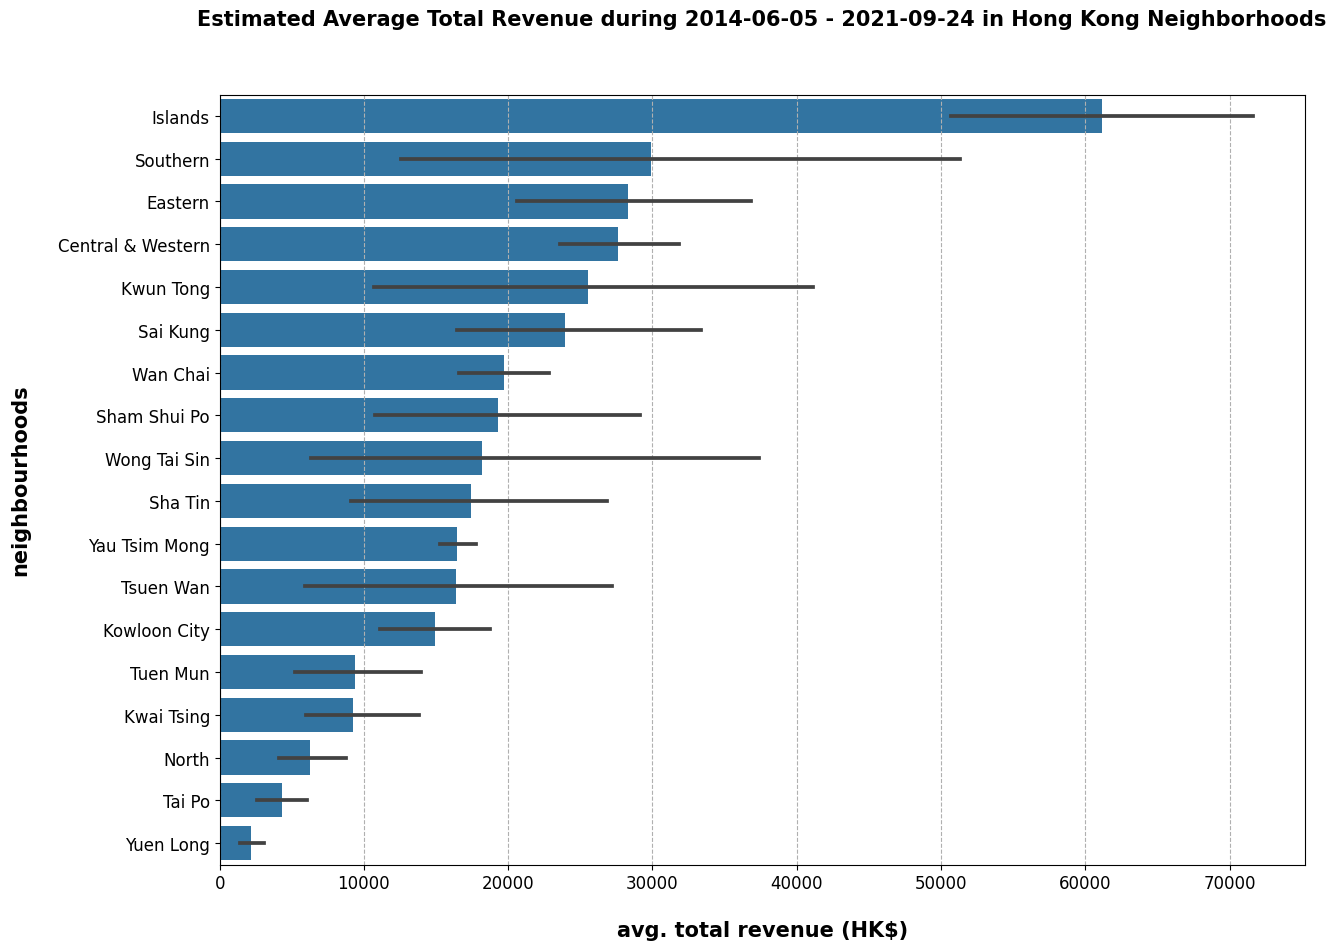

In [67]:
# Set plot preference
plt.style.use(style = 'default')

plt.figure(figsize = (14, 10))
base_color = sns.color_palette()[0]

sns.barplot(data = listing_df_Q1_cal, \
            x = 'total_revenue', \
            y = 'neighbourhood_cleansed', \
            order = df_average_revenue_of_neighbourhood.index, \
            orient = 'h', \
            color = base_color)

# grid line formatting
plt.grid(axis = 'x', linestyle = '--')

# ticks formatting
tick_fontsize = 12
plt.xticks(fontsize = tick_fontsize)
plt.yticks(fontsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 15, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 50
plt.xlabel('avg. total revenue (HK$)', fontdict = label_fontdict, labelpad = labelpad)
plt.ylabel('neighbourhoods', fontdict = label_fontdict, labelpad = labelpad)
plt.title('Estimated Average Total Revenue during 2014-06-05 - 2021-09-24 in Hong Kong Neighborhoods', \
           fontdict = label_fontdict, \
           pad = pad);

plt.savefig("figures/Q1.png", bbox_inches = 'tight');

# **Q2: Worth to be superhost?**

## prepare listing dataframe for Q2

In [68]:
# Prepare listing dataframe for Q2
column_for_Q2 = \
['id', 'neighbourhood_cleansed', 'price', \
'minimum_nights', 'number_of_reviews', 'first_review', \
'last_review', 'host_since', 'host_is_superhost']

listing_df_Q2 = listing_df[column_for_Q2].copy()

In [69]:
# Check data cleanliness
print(listing_df_Q2.duplicated(subset = ['id']).sum(), '\n')
print(listing_df_Q2.isnull().sum())

0 

id                           0
neighbourhood_cleansed       0
price                        0
minimum_nights               0
number_of_reviews            0
first_review              3067
last_review               3067
host_since                   1
host_is_superhost            1
dtype: int64


In [70]:
# Data cleaning
listing_df_Q2.dropna(subset = ['first_review', 'last_review', 'host_since', 'host_is_superhost'], \
                     how = 'any', \
                     inplace = True)

print(listing_df_Q2.isnull().sum())

id                        0
neighbourhood_cleansed    0
price                     0
minimum_nights            0
number_of_reviews         0
first_review              0
last_review               0
host_since                0
host_is_superhost         0
dtype: int64


In [71]:
# Data Wrangling
listing_df_Q2.rename(columns={'id':'listing_id'}, inplace = True)
listing_df_Q2['price'] = listing_df_Q2['price'].str.replace("[$,]", "").astype("float")
listing_df_Q2['first_review'] = pd.to_datetime(listing_df_Q2['first_review'])
listing_df_Q2['last_review'] = pd.to_datetime(listing_df_Q2['last_review'])
listing_df_Q2['host_since'] = pd.to_datetime(listing_df_Q2['host_since'])
listing_df_Q2['host_is_superhost'] = listing_df_Q2['host_is_superhost'].map({"t": True, "f": False})

C:\Users\USER\AppData\Local\Temp/ipykernel_10628/2290854248.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  listing_df_Q2['price'] = listing_df_Q2['price'].str.replace("[$,]", "").astype("float")


In [72]:
listing_df_Q2

,listing_id,neighbourhood_cleansed,price,minimum_nights,number_of_reviews,first_review,last_review,host_since,host_is_superhost
0,17891,Central & Western,1400.0,2,73,2016-03-10,2017-11-29,2010-01-09,False
1,69074,Central & Western,1429.0,2,135,2012-06-29,2019-08-03,2010-07-07,False
2,103760,Central & Western,690.0,2,274,2014-06-04,2019-11-17,2010-11-30,False
3,104626,Central & Western,2556.0,1,14,2011-11-23,2012-01-13,2011-04-29,False
4,132773,Central & Western,849.0,2,209,2014-10-26,2020-08-07,2010-11-30,False
...,...,...,...,...,...,...,...,...,...
5922,51804866,Wan Chai,998.0,21,2,2021-08-29,2021-08-31,2016-01-17,False
5968,52042692,Islands,1500.0,2,3,2021-09-06,2021-09-21,2014-11-03,False
6009,52196922,Kowloon City,1257.0,1,4,2021-09-12,2021-09-18,2018-11-06,False
6010,52208871,Wan Chai,686.0,1,1,2021-09-19,2021-09-19,2020-10-02,False


## Calculate estimated average annual revenue

In [73]:
listing_df_Q2_cal = listing_df_Q2.copy()

# Remove listings with abnormal review number
listing_df_Q2_cal['max_possible_review_num'] = \
( (listing_df_Q2_cal.loc[:, 'last_review'] \
   - listing_df_Q2_cal.loc[:, 'first_review']) \
   / listing_df_Q2_cal.loc[:, 'minimum_nights'] ).dt.days

listing_df_Q2_cal['difference'] = \
listing_df_Q2_cal.loc[:, 'max_possible_review_num'] \
- listing_df_Q2_cal.loc[:, 'number_of_reviews']

listing_df_Q2_cal = \
listing_df_Q2_cal[ (listing_df_Q2_cal['difference'] >= 0) | (listing_df_Q2_cal['number_of_reviews'] == 1)].copy()


# Calculate listings' estimated revenue of each booking
listing_df_Q2_cal['estimated_revenue'] = \
listing_df_Q2_cal.loc[:, 'price'] * listing_df_Q2_cal.loc[:, 'minimum_nights']


# Calculate listings' estimated total revenue
listing_df_Q2_cal['total_revenue'] = \
listing_df_Q2_cal.loc[:, 'estimated_revenue'] * listing_df_Q2_cal.loc[:, 'number_of_reviews']


# Calculate listings' estimated average annual revenue
end_date = np.datetime64('2021-09-24')
listing_df_Q2_cal['avg_revenue_per_year'] = \
listing_df_Q2_cal.loc[:, 'total_revenue'] / ((end_date - listing_df_Q2_cal.loc[:, 'host_since']) / np.timedelta64(1, 'Y'))
listing_df_Q2_cal['avg_revenue_per_year'] = listing_df_Q2_cal['avg_revenue_per_year'].astype(int)

## plotting

In [74]:
# Seperate the dataframe, listing_df_Q2_cal, into superhost and non-superhost dataframes
df_temp = listing_df_Q2_cal[['host_is_superhost', 'avg_revenue_per_year']].set_index('host_is_superhost').stack()
df_false = df_temp.xs(False, level = ("host_is_superhost")).reset_index(drop = True).copy()
df_true = df_temp.xs(True, level = ("host_is_superhost")).reset_index(drop = True).copy()


# Remove outliers in df_true & df_false
for df in (df_true, df_false):

    Q1 = np.percentile(df, 25, interpolation = 'midpoint')
    Q3 = np.percentile(df, 75, interpolation = 'midpoint')

    IQR = Q3 - Q1

    above_upper_bound = np.where( df >= (Q3 + 1.5 * IQR) )
    below_lower_bound = np.where( df <= (Q3 - 1.5 * IQR) )

    df.drop(above_upper_bound[0], inplace = True)
    df.drop(below_lower_bound[0], inplace = True)

    df.reset_index(drop = True, inplace = True)

In [75]:
# Obtain confidence interval for medians of superhost and non-superhost 
# and difference of medians of them by bootstraping

median_list_super = []
median_list_non_super = []
median_diff_list = []

for _ in range(10000):
    
    sample_super = df_true.sample(200, replace = True)
    sample_non_super = df_false.sample(200, replace = True)

    median_super = sample_super.median()
    median_non_super = sample_non_super.median()

    median_list_super.append(median_super)
    median_list_non_super.append(median_non_super)
    median_diff_list.append(median_super - median_non_super)

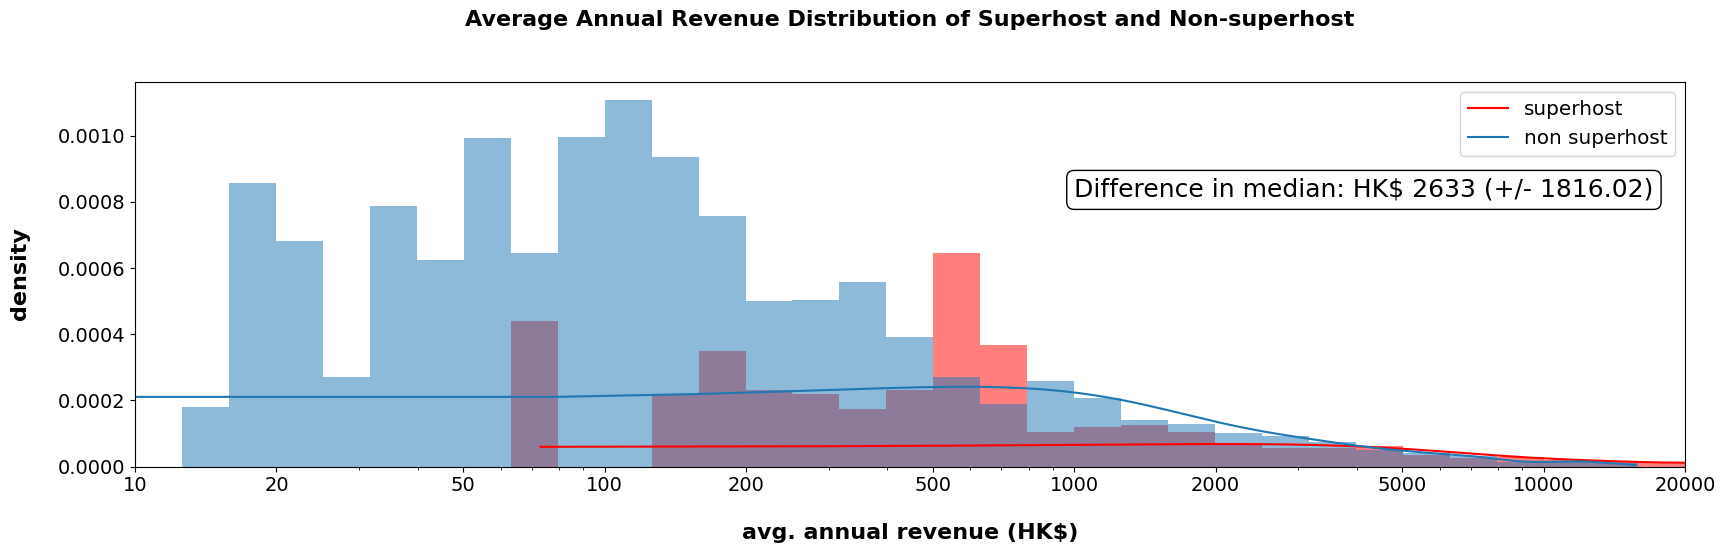

In [76]:
#Plot the distribution

# Set plot preference
plt.style.use(style = 'default')

plt.figure(figsize = [20, 5])

# main plots
bin_size = 0.1
df_true_log = np.log10(df_true)
max_value = round(df_true_log.max(), 1)
bins = 10 ** np.arange(0, max_value + bin_size, bin_size)
sns.histplot(data = df_true, \
             bins = bins, \
             stat = 'density', \
             kde = True, \
             color = 'red')
sns.histplot(data = df_false, \
             bins = bins, \
             stat = 'density', \
             kde = True)

# Indicate the difference in median of 2 groups with confidence interval
sample_median_diff = df_true.median() - df_false.median()
margin_error = \
(np.percentile(median_diff_list, 99.5) - np.percentile(median_diff_list, 0.5)) / 2

output_string = f"Difference in median: HK${sample_median_diff: n} (+/-{margin_error: n})"
props = dict(boxstyle = 'round', facecolor = 'white', alpha = 1)
plt.text(1000, 0.0008, \
         output_string , fontsize = 18, \
         verticalalignment = 'bottom', bbox = props)

plt.legend(['superhost','non superhost'], fontsize = 'x-large')

# set limit for x-asis & scale the x-axis to log
plt.xscale('log')
plt.xlim([10 ** 1, 10 ** 4])

# ticks labeling
ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000]
labels = ['{}'.format(v) for v in ticks]
plt.xticks(ticks, labels)

# ticks formatting
tick_fontsize = 14
plt.xticks(fontsize = tick_fontsize)
plt.yticks(fontsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 40
plt.xlabel('avg. annual revenue (HK$)', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.ylabel('density', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.title('Average Annual Revenue Distribution of Superhost and Non-superhost', \
          fontdict = label_fontdict, \
          pad = pad);

plt.savefig("figures/Q2.png", bbox_inches = 'tight');

# ***Q3: Cheaper & non-peak period***

## prepare review & calendar dataframes for Q3

In [77]:
# Prepare review dataframe for Q3
review_df_Q3 = review_df.copy()

In [78]:
# Check data cleanliness
print(review_df_Q3.isnull().sum())

listing_id    0
date          0
dtype: int64


In [79]:
# Data Wrangling
review_df_Q3['date'] = pd.to_datetime(review_df_Q3['date']) # convert to datetime

In [80]:
review_df_Q3

,listing_id,date
0,17891,2010-04-23
1,17891,2010-06-24
2,17891,2010-08-09
3,17891,2010-09-09
4,17891,2010-09-29
...,...,...
106504,52196922,2021-09-13
106505,52196922,2021-09-17
106506,52196922,2021-09-18
106507,52208871,2021-09-19


In [81]:
# Prepare calendar dataframe for Q3
calendar_df_Q3 = calendar_df[ ['listing_id', 'date', 'adjusted_price'] ].copy()

In [82]:
# Data Wrangling
calendar_df_Q3['date'] = pd.to_datetime(calendar_df_Q3['date']) # convert to datetime
calendar_df_Q3['adjusted_price'] = calendar_df_Q3['adjusted_price'].str.replace("[$,]", "").astype("float")

C:\Users\USER\AppData\Local\Temp/ipykernel_10628/3854838961.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  calendar_df_Q3['adjusted_price'] = calendar_df_Q3['adjusted_price'].str.replace("[$,]", "").astype("float")


In [83]:
# Check data cleanliness
print(calendar_df_Q3.duplicated().sum(), '\n')
print(calendar_df_Q3.isna().sum())

0 

listing_id          0
date                0
adjusted_price    191
dtype: int64


In [84]:
# Data cleaning
calendar_df_Q3.dropna(subset = ['adjusted_price'], how = 'any', inplace = True)
print(calendar_df_Q3.isnull().sum())

listing_id        0
date              0
adjusted_price    0
dtype: int64


In [85]:
calendar_df_Q3

,listing_id,date,adjusted_price
0,728126,2021-09-25,495.0
1,1980360,2021-09-25,250.0
2,1980360,2021-09-26,250.0
3,1980360,2021-09-27,250.0
4,1980360,2021-09-28,250.0
...,...,...,...
2206421,52295948,2022-09-20,710.0
2206422,52295948,2022-09-21,710.0
2206423,52295948,2022-09-22,710.0
2206424,52295948,2022-09-23,710.0


## calculate monthly review number

In [86]:
# Calculate monthly review number
df_monthly_review_num = review_df_Q3.set_index('date').resample('MS').count()

# Decomposing the time series
decomposition = seasonal_decompose(df_monthly_review_num)

# Get the trend, seasonality and noise
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

## [plotting] identify the non-peak period

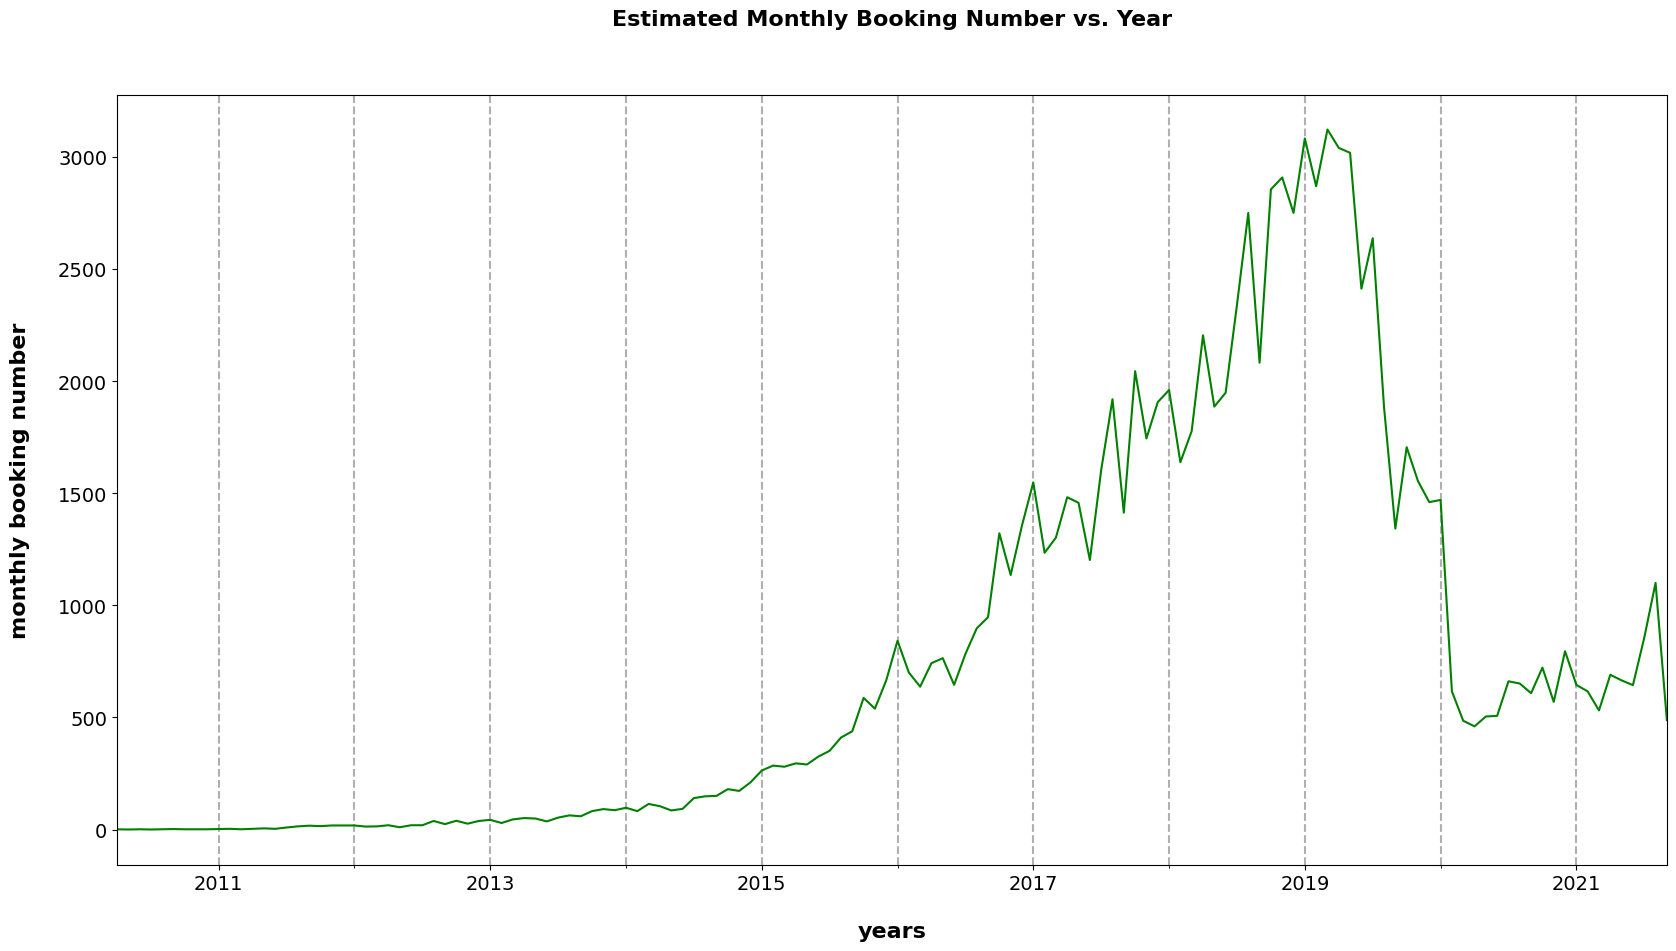

In [87]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))

df_monthly_review_num.plot(kind = 'line', \
                           color = 'green', \
                           ax = ax, \
                           legend = False)

# setting limit for x-asis; Limiting to whole months
ax.set_xlim('2010-04-01', '2021-09-30')

# grid line formatting
ax.grid(b = True, which = 'both', axis = 'x', linestyle = '--', linewidth = 1.5)

# ticks formatting
tick_fontsize = 14
ax.tick_params(axis = 'both', labelsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 50
ax.set_xlabel('years', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_ylabel('monthly booking number', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title('Estimated Monthly Booking Number vs. Year', \
             fontdict = label_fontdict, \
             pad = pad);

plt.savefig("figures/Q3_1.png", bbox_inches = 'tight');

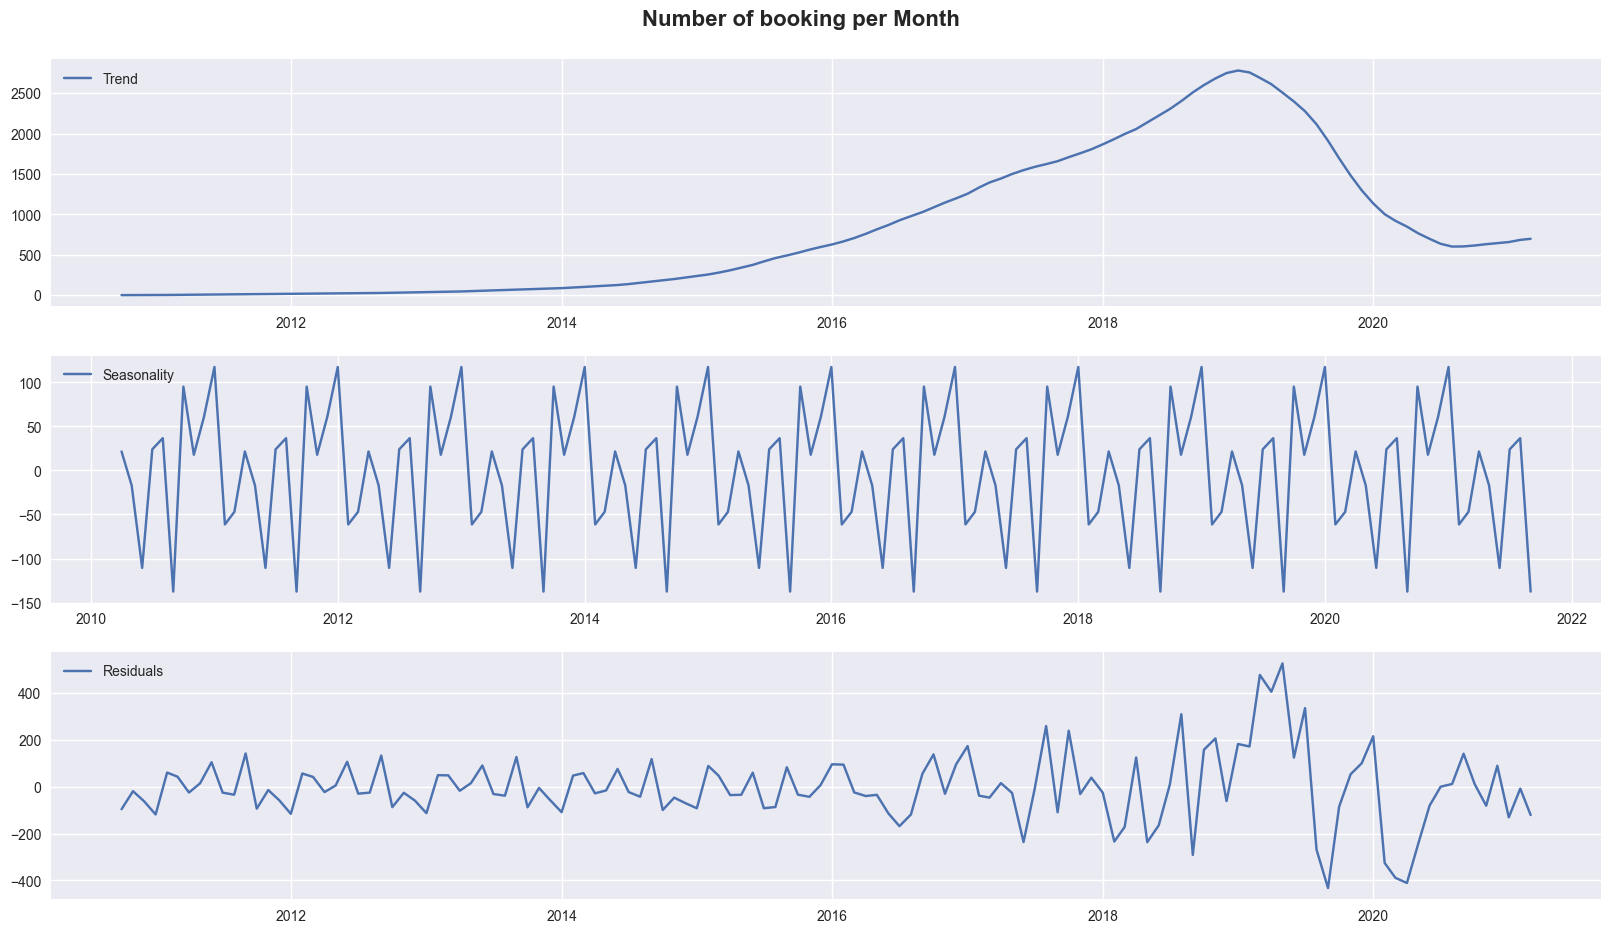

In [88]:
# Set plot preference
plt.style.use(style = 'seaborn')

# plot the decomposition
plt.figure(figsize = (20, 10))

# plot trend
plt.subplot(3, 1, 1)
plt.plot(trend, label = 'Trend')
plt.legend(loc='upper left')

# plot seasonality
plt.subplot(3, 1, 2)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'upper left')

# plot noise
plt.subplot(3, 1, 3)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'upper left')

# suptitle formatting
plt.suptitle('Number of booking per Month', y = 1, fontsize = 16, fontweight = 'semibold')
plt.subplots_adjust(top = 0.95)

plt.savefig("figures/Q3_2.png", bbox_inches = 'tight');

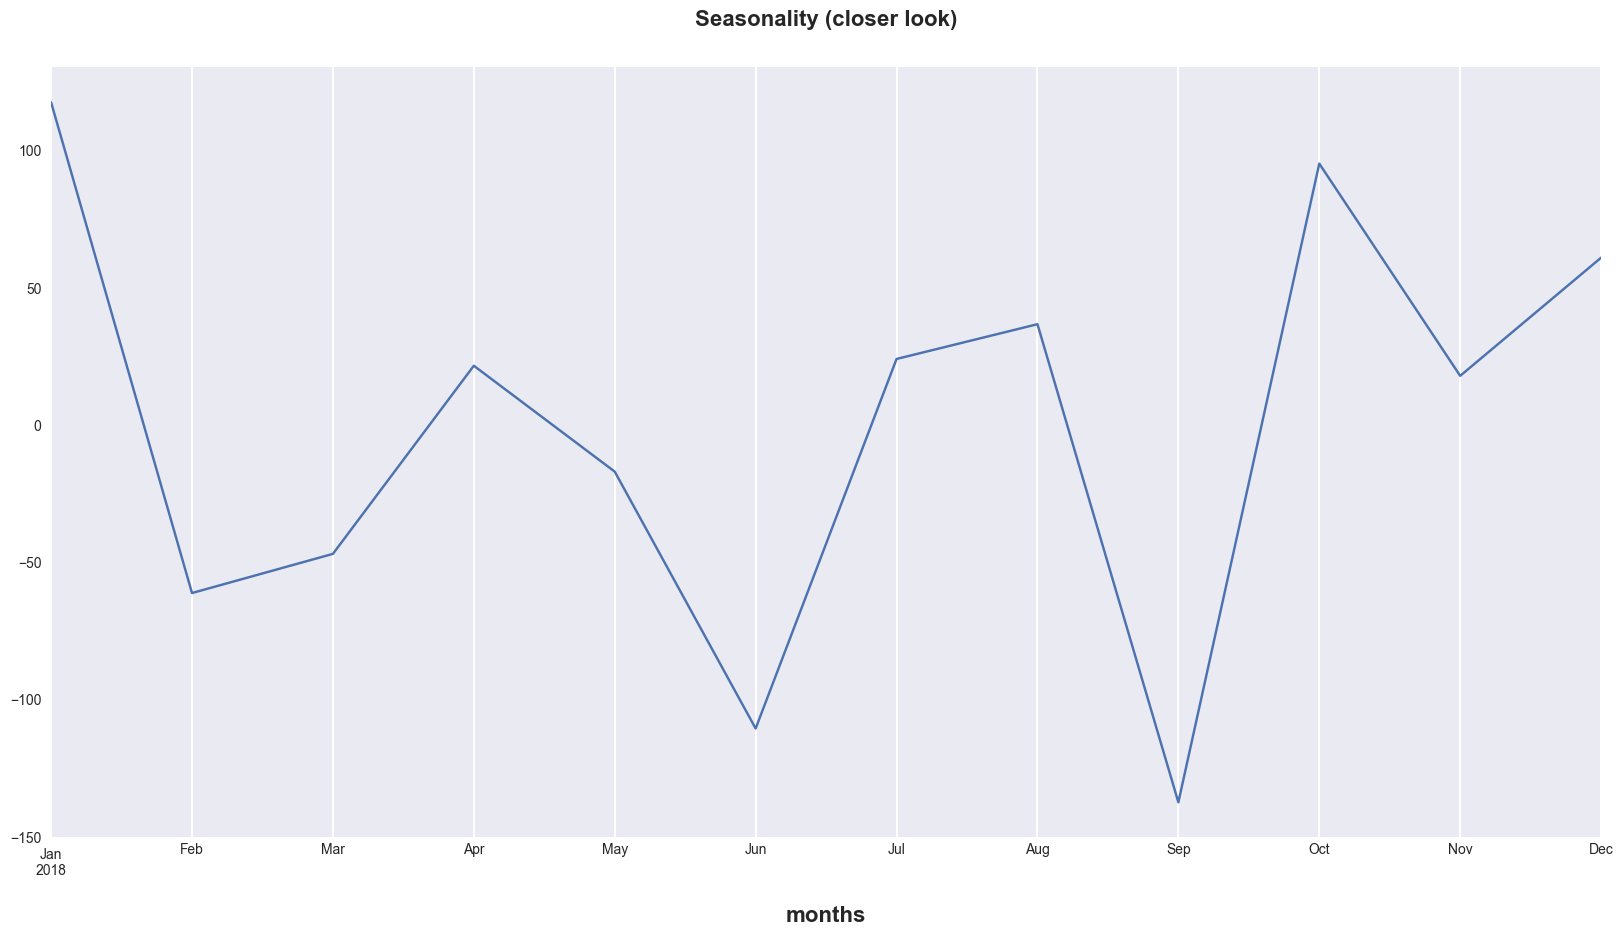

In [89]:
# Set plot preference
plt.style.use(style = 'seaborn-dark')

df_2018 = seasonal[ pd.DatetimeIndex(seasonal.index).year == 2018 ]

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))

df_2018.plot(kind = 'line', \
             ax = ax, \
             legend = False)

ax.grid(b = True, which = 'both', axis = 'x', linestyle = '-', linewidth = 1.5)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 30
ax.set_xlabel('months', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title('Seasonality (closer look)', \
             fontdict = label_fontdict, \
             pad = pad);

plt.savefig("figures/Q3_3.png", bbox_inches = 'tight');

## calculate average monthly price

In [90]:
month_mean = calendar_df_Q3.groupby(calendar_df_Q3['date'].dt.strftime('%m'), sort = True)['adjusted_price'].mean()

## [plotting] average monthly price

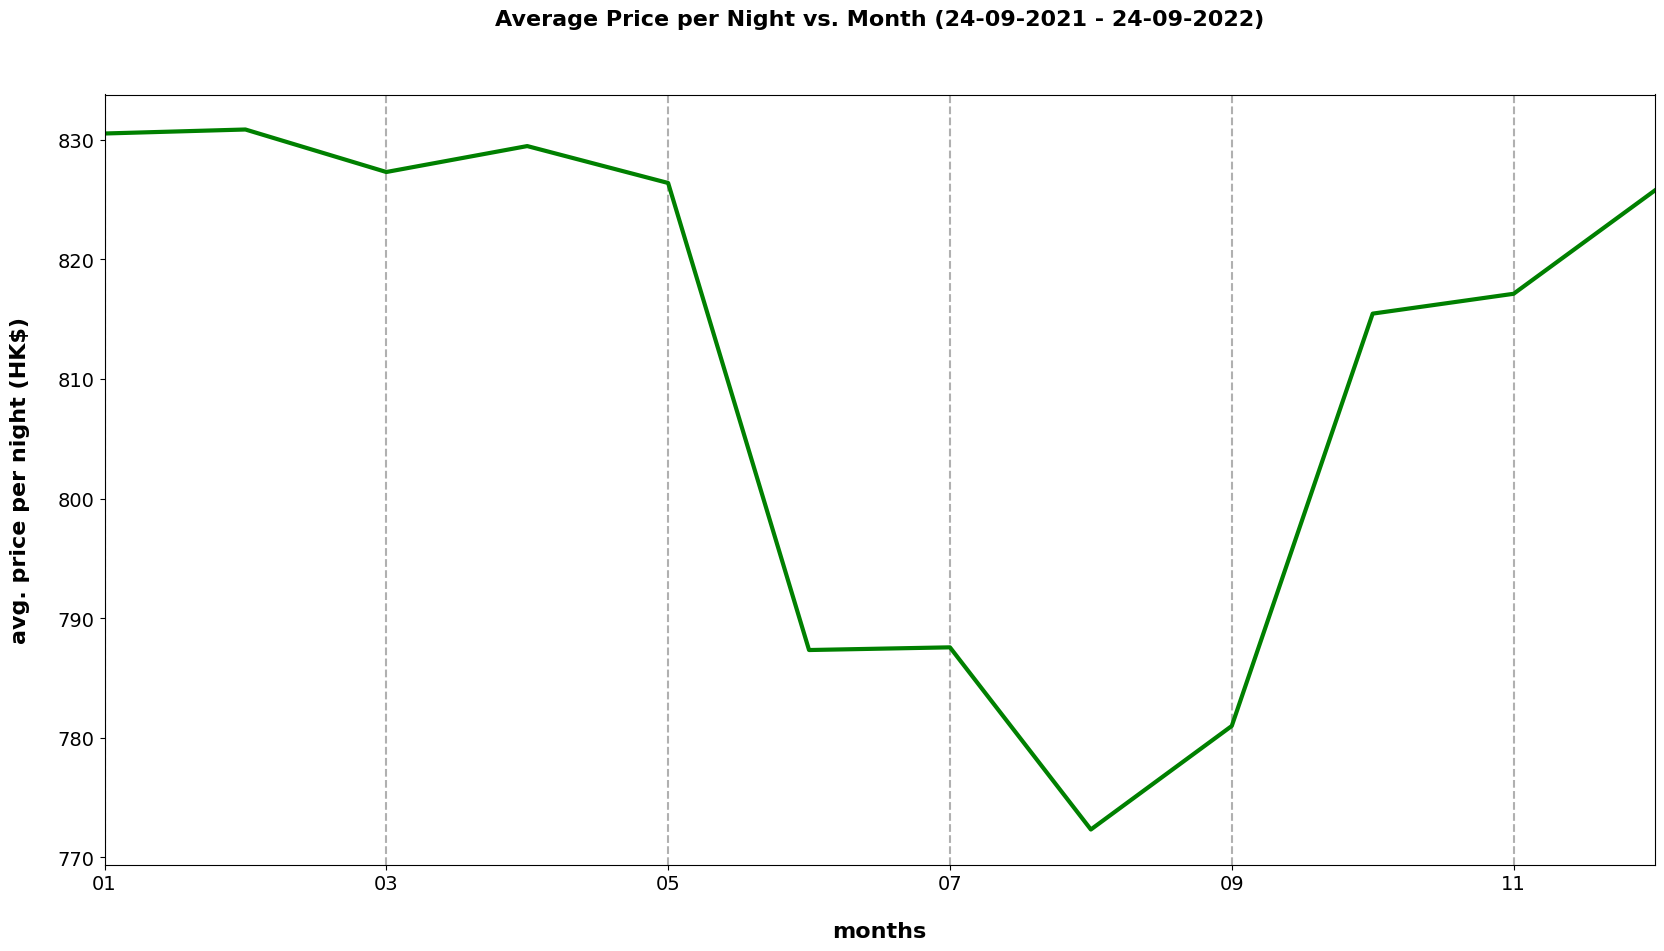

In [91]:
# Set plot preference
plt.style.use(style = 'default')

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))

month_mean.plot(kind = 'line', \
                color = 'green', \
                ax = ax, \
                linewidth = 3, \
                legend = False)

# setting limit for x-asis;
ax.set_xlim(0, 11)

# grid line formatting
ax.grid(b = True, which = 'both', axis = 'x', linestyle = '--', linewidth = 1.5)

# ticks formatting
tick_fontsize = 14
ax.tick_params(axis = 'both', labelsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 50
ax.set_xlabel('months', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_ylabel('avg. price per night (HK$)', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title('Average Price per Night vs. Month (24-09-2021 - 24-09-2022)', \
             fontdict = label_fontdict, \
             pad = pad);

plt.savefig("figures/Q3_4.png", bbox_inches = 'tight');

# **Q4: Price per Night Distribution**

## prepare listing dataframe for Q3

In [92]:
# Prepare listing dataframe for Q4

column_for_Q4 = ['id', 'neighbourhood_cleansed', 'price', 'accommodates', 'number_of_reviews']
listing_df_Q4 = listing_df[column_for_Q4].copy()

In [93]:
# Check data cleanliness

print(listing_df_Q4.duplicated(subset = ['id']).sum(), '\n')
print(listing_df_Q4.isnull().sum())

0 

id                        0
neighbourhood_cleansed    0
price                     0
accommodates              0
number_of_reviews         0
dtype: int64


In [94]:
# Data Wrangling

listing_df_Q4.rename(columns={'id':'listing_id'}, inplace = True)
listing_df_Q4['price'] = listing_df_Q4['price'].str.replace("[$,]", "").astype("float")

C:\Users\USER\AppData\Local\Temp/ipykernel_10628/1361292688.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  listing_df_Q4['price'] = listing_df_Q4['price'].str.replace("[$,]", "").astype("float")


In [95]:
listing_df_Q4

,listing_id,neighbourhood_cleansed,price,accommodates,number_of_reviews
0,17891,Central & Western,1400.0,3,73
1,69074,Central & Western,1429.0,3,135
2,103760,Central & Western,690.0,6,274
3,104626,Central & Western,2556.0,2,14
4,132773,Central & Western,849.0,6,209
...,...,...,...,...,...
6041,52374889,Wan Chai,224.0,1,0
6042,52379537,Central & Western,700.0,2,0
6043,52387906,Central & Western,700.0,4,0
6044,52395141,Yau Tsim Mong,1570.0,1,0


## remove outliers in each neighborhood and calculate median price of each neighborhood

In [96]:
listing_df_Q4_cal = listing_df_Q4.copy()


# Remove outliers in each neighbourhood 

listing_df_Q4_cal.reset_index(drop = True, inplace = True)

neighbourhood_list = listing_df_Q4['neighbourhood_cleansed'].unique().tolist()

for nb in neighbourhood_list:

    df_temp = listing_df_Q4_cal[ listing_df_Q4_cal['neighbourhood_cleansed'] == nb ]['price']

    Q1 = np.percentile(df_temp, 25, interpolation = 'midpoint')
    Q3 = np.percentile(df_temp, 75, interpolation = 'midpoint')

    IQR = Q3 - Q1

    above_upper_bound = np.where( (listing_df_Q4_cal['price'] >= (Q3 + 1.5 * IQR)) \
                                    & (listing_df_Q4['number_of_reviews'] == 0) \
                                    & (listing_df_Q4_cal['neighbourhood_cleansed'] == nb) )
    below_lower_bound = np.where( (listing_df_Q4_cal['price'] <= (Q3 - 1.5 * IQR)) \
                                    & (listing_df_Q4['number_of_reviews'] == 0) \
                                    & (listing_df_Q4_cal['neighbourhood_cleansed'] == nb) )

    listing_df_Q4_cal.drop(above_upper_bound[0], inplace = True)
    listing_df_Q4_cal.drop(below_lower_bound[0], inplace = True)

    listing_df_Q4_cal.reset_index(drop = True, inplace = True)

In [97]:
# abnormal listings found manually
abnormal_listing = \
np.where(listing_df_Q4_cal['listing_id'].isin([25790587, 25812645, 25814703, 25919364, 25950368, 43345284]))
listing_df_Q4_cal.drop(abnormal_listing[0], inplace = True)
listing_df_Q4_cal.reset_index(drop = True, inplace = True)

In [98]:
# Median price by neighborhood
median_price_by_neighbourhood = \
listing_df_Q4_cal[['neighbourhood_cleansed', 'price']] \
              .groupby(by = ['neighbourhood_cleansed']) \
              .median() \
              .sort_values(by = ['price'], ascending = False)

In [99]:
median_price_by_neighbourhood

,price
neighbourhood_cleansed,
Kwai Tsing,999.0
Southern,988.0
Islands,850.0
Tai Po,629.0
Sai Kung,518.5
Tsuen Wan,490.0
Tuen Mun,486.0
Central & Western,454.0
Kwun Tong,439.0


## plotting

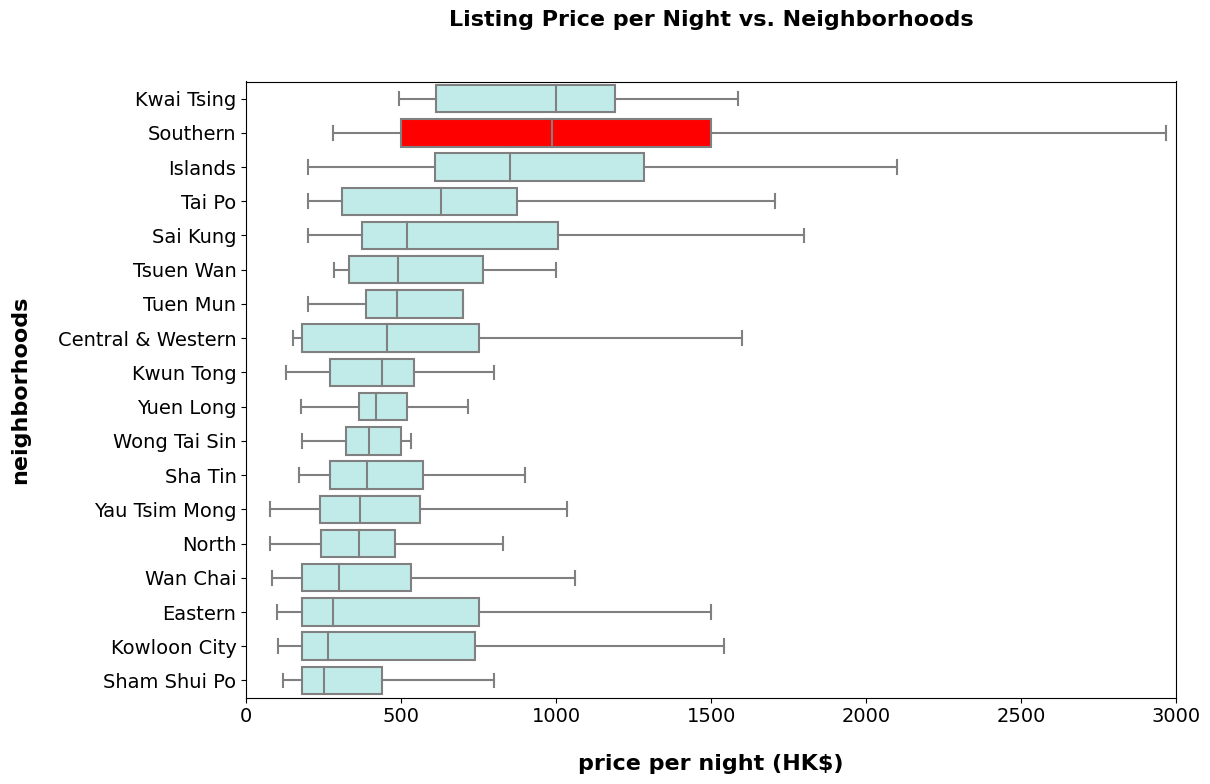

In [100]:
# Boxplot of listing price by neighborhood
plt.figure(figsize=(12, 8))
base_color = sns.color_palette("pastel")[-1]

ax = sns.boxplot(x = "price", \
            y = "neighbourhood_cleansed", \
            data = listing_df_Q4_cal, \
            orient = 'h', \
            order = median_price_by_neighbourhood.index,\
            color = base_color, \
            showfliers = False)

# Indicate which box has widest dispersion
target_box = ax.artists[1]
target_box.set_facecolor('red')

# setting limit for x-asis
plt.xlim([0, 3000])

# ticks formatting
tick_fontsize = 14
plt.xticks(fontsize = tick_fontsize)
plt.yticks(fontsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 40
plt.xlabel('price per night (HK$)', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.ylabel('neighborhoods', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.title('Listing Price per Night vs. Neighborhoods', \
          fontdict = label_fontdict, \
          pad = pad);

plt.savefig("figures/Q4_1.png", bbox_inches = 'tight');

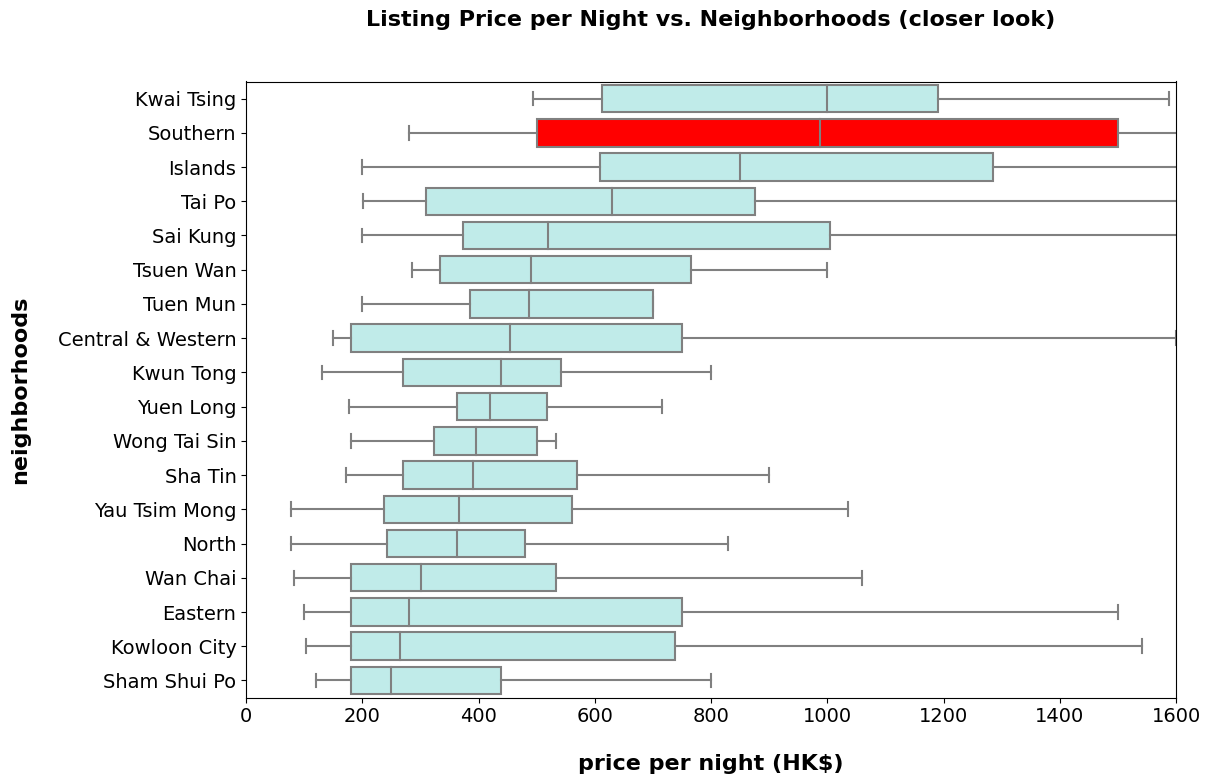

In [101]:
# Boxplot of listing price by neighborhood
plt.figure(figsize=(12, 8))
base_color = sns.color_palette("pastel")[-1]

ax = sns.boxplot(x = "price", \
            y = "neighbourhood_cleansed", \
            data = listing_df_Q4_cal, \
            orient = 'h', \
            order = median_price_by_neighbourhood.index,\
            color = base_color, \
            showfliers = False)

# Indicate which box has widest dispersion
target_box = ax.artists[1]
target_box.set_facecolor('red')

# setting limit for x-asis
plt.xlim([0, 1600])

# ticks formatting
tick_fontsize = 14
plt.xticks(fontsize = tick_fontsize)
plt.yticks(fontsize = tick_fontsize)

# labels & title formatting
label_fontdict = \
{'fontsize': 16, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 40
plt.xlabel('price per night (HK$)', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.ylabel('neighborhoods', \
           fontdict = label_fontdict, \
           labelpad = labelpad)
plt.title('Listing Price per Night vs. Neighborhoods (closer look)', \
          fontdict = label_fontdict, \
          pad = pad);

plt.savefig("figures/Q4_2.png", bbox_inches = 'tight');

In [102]:
# Check IQR & min-max range of Southern
df_temp = listing_df_Q4_cal[listing_df_Q4_cal.neighbourhood_cleansed == 'Southern']['price']

# IQR
print(np.percentile(df_temp, 25, interpolation = 'midpoint'), np.percentile(df_temp, 75, interpolation = 'midpoint'))

# min-max range
print(df_temp.min(), df_temp.max())

500.0 1500.0
280.0 5060.0


# ***Q5: Impact of 2019 HK protests and 2019-COVID outbreak***

## prepare listing & review dataframe for Q5

In [103]:
# Obtain from Q1
listing_df_Q5

,listing_id,neighbourhood_cleansed,price,minimum_nights,host_since,first_review,last_review,number_of_reviews,review_num_after_2014_06_05,max_possible_review_num,difference,estimated_revenue,total_revenue
0,17891,Central & Western,1400.0,2,2010-01-09,2016-03-10,2017-11-29,73,23,314,241,2800.0,64400.0
1,69074,Central & Western,1429.0,2,2010-07-07,2012-06-29,2019-08-03,135,109,1295,1160,2858.0,311522.0
2,103760,Central & Western,690.0,2,2010-11-30,2014-06-04,2019-11-17,274,165,996,722,1380.0,227700.0
3,132773,Central & Western,849.0,2,2010-11-30,2014-10-26,2020-08-07,209,131,1056,847,1698.0,222438.0
4,163664,Central & Western,615.0,2,2010-11-30,2013-09-23,2020-01-31,225,152,1160,935,1230.0,186960.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,51804251,Sai Kung,2800.0,2,2019-03-19,2021-09-02,2021-09-22,4,4,10,6,5600.0,22400.0
2950,52042692,Islands,1500.0,2,2014-11-03,2021-09-06,2021-09-21,3,3,7,4,3000.0,9000.0
2951,52196922,Kowloon City,1257.0,1,2018-11-06,2021-09-12,2021-09-18,4,4,6,2,1257.0,5028.0
2952,52208871,Wan Chai,686.0,1,2020-10-02,2021-09-19,2021-09-19,1,1,0,-1,686.0,686.0


In [104]:
# Prepare review dataframe for Q5
review_df_Q5 = review_df.copy()

In [105]:
# Data Wrangling
review_df_Q5['date'] = pd.to_datetime(review_df_Q5['date']) # convert to datetime

In [106]:
review_df_Q5

,listing_id,date
0,17891,2010-04-23
1,17891,2010-06-24
2,17891,2010-08-09
3,17891,2010-09-09
4,17891,2010-09-29
...,...,...
106504,52196922,2021-09-13
106505,52196922,2021-09-17
106506,52196922,2021-09-18
106507,52208871,2021-09-19


## calculate revenue during (2018-06-15 - 2019-01-15), (2019-06-15 - 2020-01-15) & (2020-06-15 - 2021-01-15)

In [107]:
review_count_2018_df = \
review_df_Q5.where((review_df_Q5['date'] >= '2018-06-15') & (review_df_Q5['date'] <= '2019-01-15'))\
            .groupby(['listing_id'])\
            .count()\
            .rename(columns={'date': 'review_num_2018'})

review_count_2019_df = \
review_df_Q5.where((review_df_Q5['date'] >= '2019-06-15') & (review_df_Q5['date'] <= '2020-01-15'))\
            .groupby(['listing_id'])\
            .count()\
            .rename(columns={'date': 'review_num_2019'})

review_count_2020_df = \
review_df_Q5.where((review_df_Q5['date'] >= '2020-06-15') & (review_df_Q5['date'] <= '2021-01-15'))\
            .groupby(['listing_id'])\
            .count()\
            .rename(columns={'date': 'review_num_2020'})

In [108]:
# Merge mulitple dataframes, and only get the listings after filtering in Q1
df_list = [listing_df_Q5, review_count_2018_df, review_count_2019_df, review_count_2020_df]

df_merged = reduce(lambda  left, right: pd.merge(left, right, on = ['listing_id'], how = 'left'), df_list)

# Assign 0 to the null elements the calculate the revenue of 2018, 2019, 2020
year = ['2018', '2019', '2020']

for x in year:
    df_merged.at[ df_merged['review_num_{}'.format(x)].isnull(), 'review_num_{}'.format(x) ] = 0
    df_merged['estimated_revenue_{}'.format(x)] = df_merged.loc[:, 'price'] * df_merged.loc[:, 'review_num_{}'.format(x)]

df_merged

,listing_id,neighbourhood_cleansed,price,minimum_nights,host_since,first_review,last_review,number_of_reviews,review_num_after_2014_06_05,max_possible_review_num,difference,estimated_revenue,total_revenue,review_num_2018,review_num_2019,review_num_2020,estimated_revenue_2018,estimated_revenue_2019,estimated_revenue_2020
0,17891,Central & Western,1400.0,2,2010-01-09,2016-03-10,2017-11-29,73,23,314,241,2800.0,64400.0,0.0,0.0,0.0,0.0,0.0,0.0
1,69074,Central & Western,1429.0,2,2010-07-07,2012-06-29,2019-08-03,135,109,1295,1160,2858.0,311522.0,21.0,3.0,0.0,30009.0,4287.0,0.0
2,103760,Central & Western,690.0,2,2010-11-30,2014-06-04,2019-11-17,274,165,996,722,1380.0,227700.0,17.0,10.0,1.0,11730.0,6900.0,690.0
3,132773,Central & Western,849.0,2,2010-11-30,2014-10-26,2020-08-07,209,131,1056,847,1698.0,222438.0,15.0,15.0,5.0,12735.0,12735.0,4245.0
4,163664,Central & Western,615.0,2,2010-11-30,2013-09-23,2020-01-31,225,152,1160,935,1230.0,186960.0,15.0,14.0,2.0,9225.0,8610.0,1230.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,51804251,Sai Kung,2800.0,2,2019-03-19,2021-09-02,2021-09-22,4,4,10,6,5600.0,22400.0,0.0,0.0,0.0,0.0,0.0,0.0
2406,52042692,Islands,1500.0,2,2014-11-03,2021-09-06,2021-09-21,3,3,7,4,3000.0,9000.0,0.0,0.0,0.0,0.0,0.0,0.0
2407,52196922,Kowloon City,1257.0,1,2018-11-06,2021-09-12,2021-09-18,4,4,6,2,1257.0,5028.0,0.0,0.0,0.0,0.0,0.0,0.0
2408,52208871,Wan Chai,686.0,1,2020-10-02,2021-09-19,2021-09-19,1,1,0,-1,686.0,686.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
year = ['2018', '2019', '2020']
column = []

for x in year:
    column.append('estimated_revenue_{}'.format(x))

df_merged[column].sum()

estimated_revenue_2018    10950281.0
estimated_revenue_2019     8094999.0
estimated_revenue_2020     4009396.0
dtype: float64

## plotting

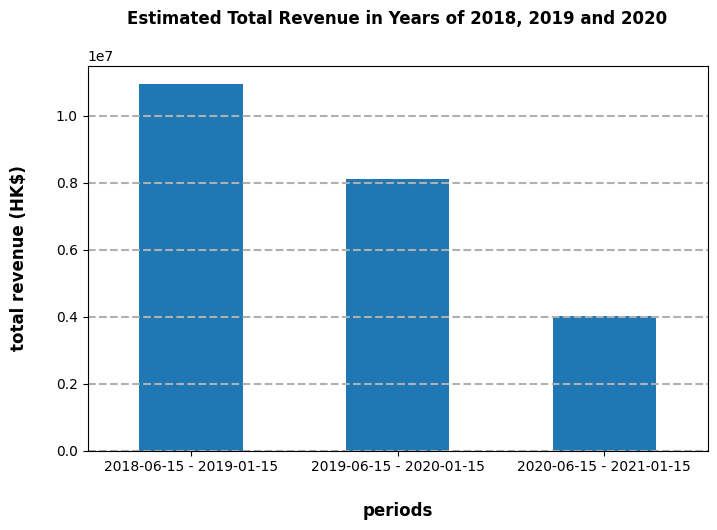

In [110]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 5))

df_merged[column].sum().plot(kind = 'bar', ax = ax)

# ticks formatting
tick_fontsize = 10
ax.set_xticklabels(labels = ['2018-06-15 - 2019-01-15', '2019-06-15 - 2020-01-15', '2020-06-15 - 2021-01-15'], \
                   rotation = 0)
ax.tick_params(axis = 'both', labelsize = tick_fontsize)

# grid line formatting
ax.grid(b = True, axis = 'y', linestyle = '--', linewidth = 1.5)

# labels & title formatting
label_fontdict = \
{'fontsize': 12, \
 'fontweight' : 'semibold'}
labelpad = 20
pad = 30
ax.set_xlabel('periods', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_ylabel('total revenue (HK$)', \
              fontdict = label_fontdict, \
              labelpad = labelpad) 
ax.set_title('Estimated Total Revenue in Years of 2018, 2019 and 2020', \
             fontdict = label_fontdict, \
             pad = pad);

plt.savefig("figures/Q5.png", bbox_inches = 'tight');